In [1]:
import numpy as np
import pandas as pd

import bct
import glob
import os
import seaborn as sns
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

from pathlib import Path
np.set_printoptions(suppress=True)


%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}

plt.rcParams.update(params)

In [16]:
# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [2]:
def module_nodes(modules, module):
    nodes = []
    
    for (key, value) in modules.items():
        if value == module:
            nodes.append(key)
            
    return nodes

In [3]:
def relative_degree(grid, nodes, node):
    all_nodes = nodes
    if not np.isin(node, nodes):
        all_nodes.append(node)
    
    return (grid.subgraph(all_nodes).degree(node))

In [4]:
def global_degree(node, grid):
    return(grid.degree(node))

In [5]:
def participation_coefficient(grid, modules, node):
    acum = 0
    number_of_modules = len(set(list(modules.values())))

    global_degree_value = global_degree(node, grid)        
    
    if global_degree_value > 0:
        for module in range(1,number_of_modules):
            relative_degree_value = relative_degree(grid, module_nodes(modules, module), node)                
            acum += pow(relative_degree_value / global_degree_value, 2)
            
    return (1-acum)        

In [6]:
def intra_modular_degree_zscore(grid, modules, node):
    module = modules[node]    
    nodes = module_nodes(modules, module)
    relative_degrees = {}
    
    for  n in nodes:
        relative_degrees[n] = relative_degree(grid, nodes, n)
    
    im_degree = relative_degrees[node]
    degrees_values = list(relative_degrees.values())
    im_mean = np.mean(degrees_values)        
    im_std_deviation = np.std(degrees_values)
    
    if im_std_deviation > 0:
        return ((im_degree - im_mean) / im_std_deviation)
    else:
        return (0)
    

In [7]:
def node_clasfication(P_c, Z_c, P_i, Z_i):
    if (P_i > P_c and Z_i > Z_c):
        return("hub")
    if (P_i <= P_c and Z_i > Z_c):
        return("provincial_hub")
    if (P_i <= P_c and Z_i <= Z_c):
        return("provincial_node")
    if (P_i > P_c and Z_i <= Z_c):
        return("connector_node")
    

In [8]:
def node_roles(G, P_c, Z_c):
    result = {}
    roles = []
    modules = community_louvain.best_partition(G)

    for node in G.nodes():
        Z_i = intra_modular_degree_zscore(G, modules, node)
        P_i = participation_coefficient(G, modules, node)
        role = node_clasfication(P_c, Z_c, P_i, Z_i)        
        result[node] = list([Z_i, P_i, role])
        roles.append(role)
    
    return([result, roles])

In [9]:
def grid_roles(G, P_c, Z_c):
    roles_stats, roles = node_roles(G, P_c, Z_c)
    unique_roles, counts = np.unique(roles, return_counts=True)
    
    result = {"hub" : 0,
              "provincial_hub": 0,
              "provincial_node": 0,
              "connector_node": 0}
    
    for i in range(0, len(unique_roles)):
        result[unique_roles[i]] = counts[i]
        
    return (result)
    

In [10]:
def subjectmatrix_to_graphs(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densidad de aristas correspondiente
    """

    correlation_matrix = pd.read_csv(
        filename,
        header=None
    )
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(
        correlation_matrix.values[tril_idx].flatten(),
        reverse=True
    )

    #Gs = []
    Gs = {}
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs[d] = nx.from_pandas_adjacency(correlation_matrix>=threshold)

    return Gs

In [11]:
def extract_graphs(tipo_red, densities):

    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + "/{}_suj*.csv".format(tipo_red))


    graphs = {}
    for filename in all_files:
        Gs = subjectmatrix_to_graphs(filename, densities)
        name = Path(filename).stem
        graphs[name] = Gs

    return graphs

In [12]:
def roles_per_state(Gs):
    roles = []
    for (sub, gs) in Gs.items():
        for (density, g) in gs.items():
            grid_roles_values = grid_roles(g, 0.05, 1)
            roles.append([density, grid_roles_values["hub"]
                            , grid_roles_values["provincial_hub"]
                            , grid_roles_values["provincial_node"]
                            , grid_roles_values["connector_node"]])
    return (np.array(roles))

In [13]:
def agregate_per_density(roles):
    result = []
        
    for d in densities:
        density_filter = np.asarray([d])
        by_density = roles[np.in1d(roles[:, 0], density_filter)]
        result.append(np.mean(by_density, axis=0))
        
    return (np.array(result))

            

In [251]:
densities = np.linspace(0.025, 0.15)

G_N1 = extract_graphs("N1", densities)
G_N2 = extract_graphs("N2", densities)
G_N3 = extract_graphs("N3", densities)
G_W = extract_graphs("W", densities)

In [252]:
roles_N1 = roles_per_state(G_N1)

In [253]:
roles_N2 = roles_per_state(G_N2)

In [254]:
roles_N3 = roles_per_state(G_N3)

In [255]:
roles_W = roles_per_state(G_W)

In [256]:
roles_mean_N1 = agregate_per_density(roles_N1)

In [257]:
roles_mean_N2 = agregate_per_density(roles_N2)

In [258]:
roles_mean_N3 = agregate_per_density(roles_N3)

In [259]:
roles_mean_W = agregate_per_density(roles_W)

In [260]:
roles_mean_N1

array([[ 0.025     ,  6.05555556,  7.22222222, 51.38888889, 51.33333333],
       [ 0.02755102,  5.94444444,  6.72222222, 51.33333333, 52.        ],
       [ 0.03010204,  6.27777778,  6.83333333, 52.83333333, 50.05555556],
       [ 0.03265306,  6.27777778,  6.72222222, 51.11111111, 51.88888889],
       [ 0.03520408,  6.88888889,  6.61111111, 50.11111111, 52.38888889],
       [ 0.0377551 ,  7.66666667,  6.55555556, 49.61111111, 52.16666667],
       [ 0.04030612,  7.61111111,  7.        , 49.88888889, 51.5       ],
       [ 0.04285714,  7.22222222,  7.05555556, 50.55555556, 51.16666667],
       [ 0.04540816,  8.72222222,  5.94444444, 49.16666667, 52.16666667],
       [ 0.04795918,  8.55555556,  5.61111111, 46.61111111, 55.22222222],
       [ 0.0505102 ,  9.55555556,  6.16666667, 46.38888889, 53.88888889],
       [ 0.05306122,  9.38888889,  5.22222222, 46.22222222, 55.16666667],
       [ 0.05561224, 10.05555556,  5.22222222, 45.11111111, 55.61111111],
       [ 0.05816327, 10.72222222,  4.8

In [261]:
def plot_Nx_vs_W_roles(Nx_roles, W_roles, title, label_nx):
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(title)
    axs[0].plot(densities, Nx_roles[:, 1], label=label_nx)
    axs[0].plot(densities, W_roles[:, 1], label='W')
    axs[0].set(ylabel='hubs')
    axs[1].plot(densities, Nx_roles[:, 2])
    axs[1].plot(densities, W_roles[:, 2])
    axs[1].set(ylabel='provincial hubs')
    axs[2].plot(densities, Nx_roles[:, 3])
    axs[2].plot(densities, W_roles[:, 3])
    axs[2].set(ylabel='provincial nodes')
    axs[3].plot(densities, Nx_roles[:, 4])
    axs[3].plot(densities, W_roles[:, 4])
    axs[3].set(ylabel='connector nodes')

    for ax in axs.flat:
        ax.set(xlabel='density')

    for ax in axs.flat:
        ax.label_outer()
        
    
    legend = axs[0].legend(loc='best', shadow=True, fontsize='x-small')

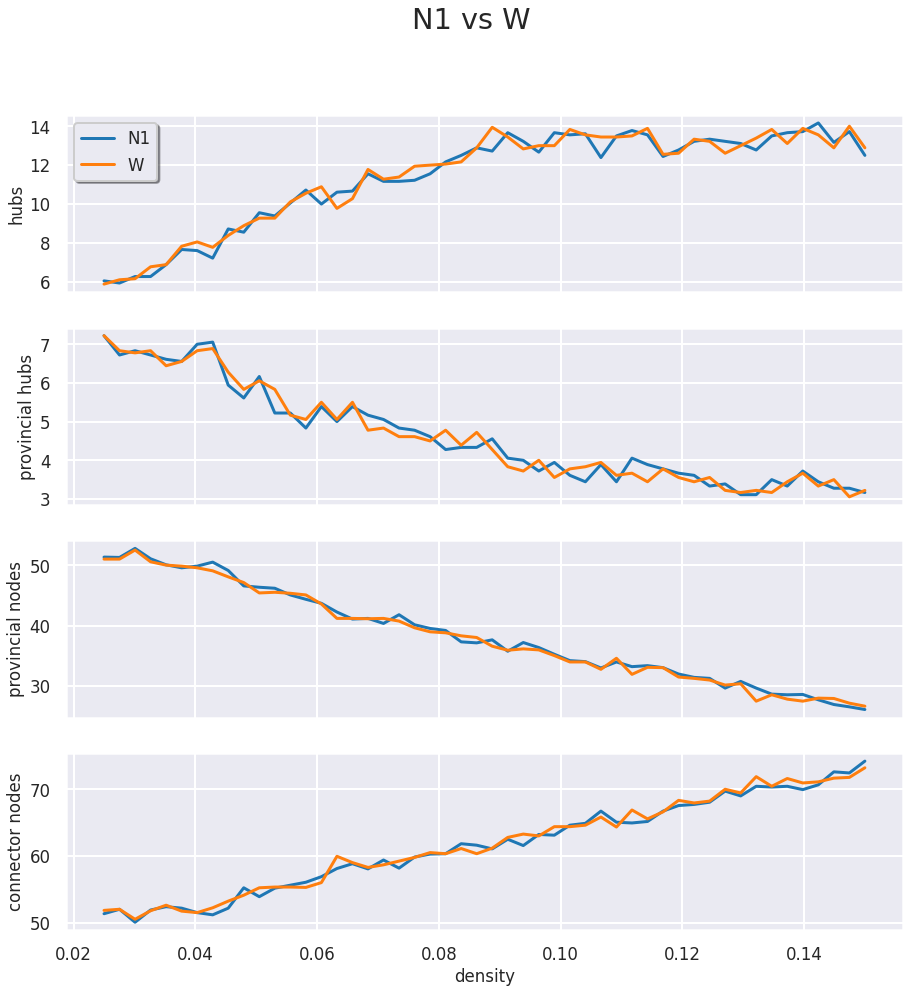

In [262]:
plot_Nx_vs_W_roles(roles_mean_N1, roles_mean_W, 'N1 vs W','N1')

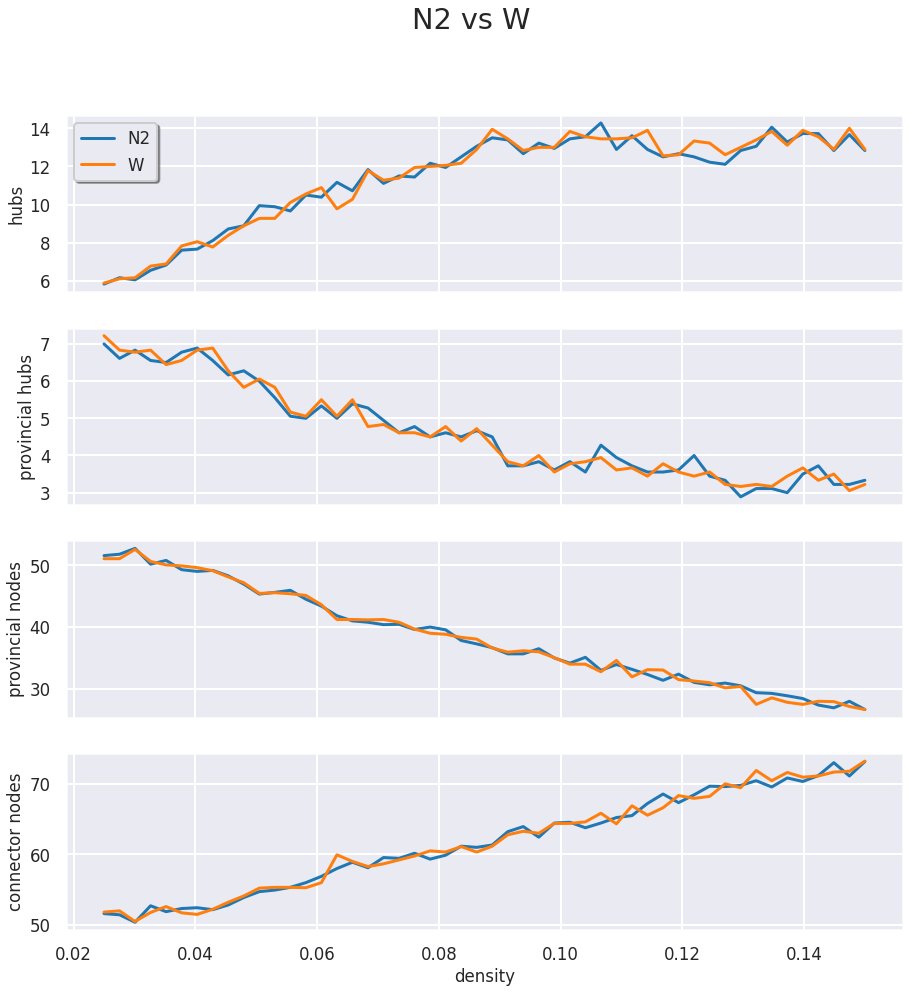

In [263]:
plot_Nx_vs_W_roles(roles_mean_N2, roles_mean_W, 'N2 vs W','N2')

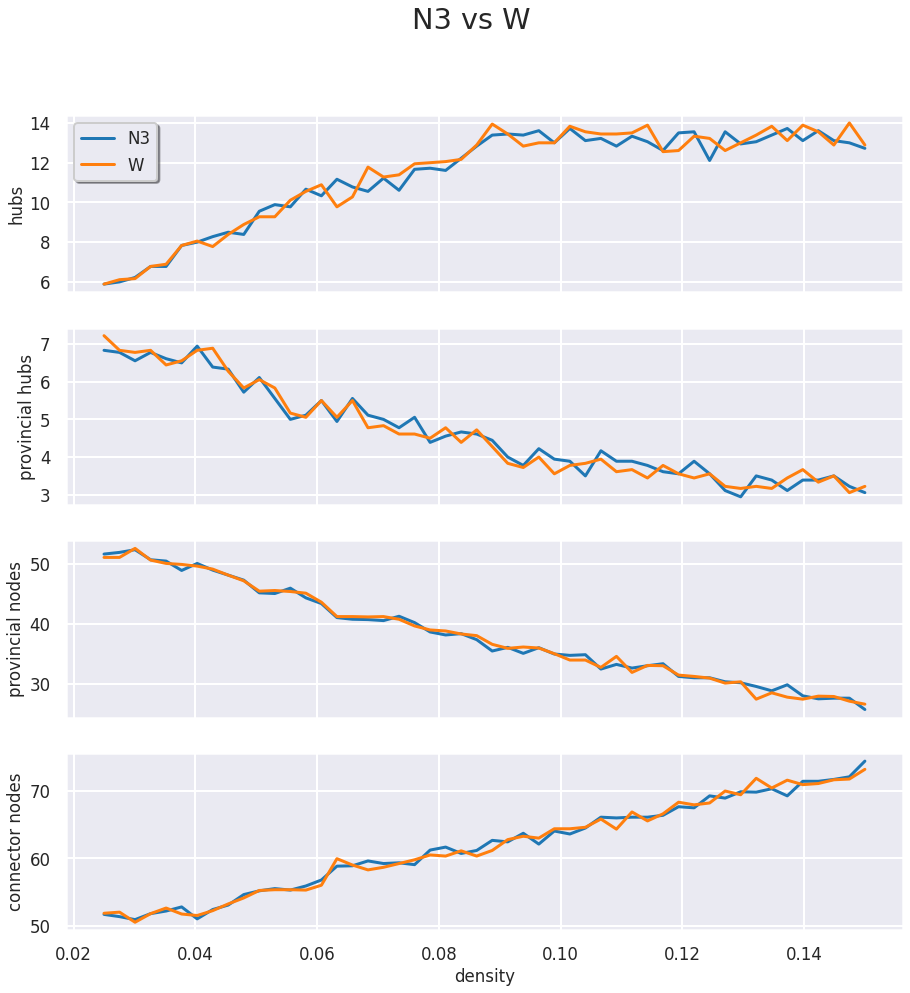

In [264]:
plot_Nx_vs_W_roles(roles_mean_N3, roles_mean_W, 'N3 vs W','N3')

In [25]:
dfLabels = pd.read_csv("../resources/aal_extended.csv",header=None) 
dfLabels.columns = ['reindex','name','mark','region','side']
dfLabels["region_side"] = dfLabels["region"] + "_" + dfLabels["side"]

print(dfLabels.head())

labels = dfLabels['name'].values

   reindex               name  mark   region side region_side
0        1       Precentral_L  2001  Central    L   Central_L
1        2       Precentral_R  2002  Central    R   Central_R
2        3      Frontal_Sup_L  2101  Frontal    L   Frontal_L
3        4      Frontal_Sup_R  2102  Frontal    R   Frontal_R
4        5  Frontal_Sup_Orb_L  2111  Frontal    L   Frontal_L


In [29]:
array_labels = ['Central_L', 'Central_R', 'Frontal_L', 'Frontal_R', 'Insula_L',
       'Insula_R', 'Cerebelum_L',
       'Cerebelum_R', 'Cerebelum_--','Limbic_L', 'Limbic_R', 'Subcortical_L',
       'Subcortical_R', 'Occipital_L', 'Occipital_R', 'Parietal_L',
       'Parietal_R', 'Temporal_L', 'Temporal_R', ]

In [30]:
NUM_COLORS=len(set(dfLabels['region_side']))
cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_map = {lab:scalarMap.to_rgba(i) for lab,i in zip(array_labels,range(len(array_labels)))}
#color_map

In [31]:
#color_map = {'Frontal': '#0173b2', 'Temporal': '#de8f05', 'Parietal': '#029e73', 'Central': '#d55e00', 'Limbic': '#cc78bc', 'Occipital': '#ca9161', 'Insula': '#fbafe4', 'Subcortical': '#949494', 'Cerebelum': '#ece133'}
def set_color(x):
    return color_map[x]
node_colors = [set_color(x) for x in dfLabels['region_side'].values]
node_network = dfLabels['region_side'].values
#node_colors

In [166]:
def plot_grafo_kamada_kawai_layout(G,tipo_red,edgewidth=1.0,node_size_param1=.1,node_size_param2=.7):
    f = plt.figure()
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

    weight_widths = [(.06 + edgewidth*x) ** 10 for x in weights]
    node_size = [(node_size_param1+node_size_param2*j)**1.55 for i, j in nx.degree(G,weight='weight')]
    
    
    
    modules = community_louvain.best_partition(G_selected)
    
    modules_values = list(modules.values())
    modules_set = set(list(modules.values()))
    
    #print(modules_values)   
    
    NUM_COLORS=len(set(modules_values))
    print(f'NUM_COLORS {NUM_COLORS}')
    cm = plt.get_cmap('tab20b')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_map2 = {lab:scalarMap.to_rgba(i) for lab,i in zip(modules_set,range(len(modules_set)))}
    color_map2    
    
    edgecolors = [color_map2[x] for x in modules_values]
    
    #print(edgecolors)
        
    layout = nx.kamada_kawai_layout(G,weight='weight')
    nx.draw_networkx_nodes(G, layout, weight='weight',
                         node_size = node_size,
                         node_color=node_colors,
                         edge_color = "skyblue", # 엣지 색상
                         # edge_color=edge_color,
                         edgecolors=edgecolors,
                         alpha = 0.9, # 노드와 엣지의 투명도
                         with_labels = True, # 노드 이름 표시 여부
                         font_size=10, # 폰트 사이즈
                         font_family='Malgun Gothic', # 한글설정
                         arrowsize = 10) # 화살표 크기
    nx.draw_networkx_labels(G, layout, font_color='k', font_size=6, weight='weight',)
    nx.draw_networkx_edges(G, layout, edgelist=edges, width=weight_widths, edge_color = "skyblue", weight='weight',)

    plt.rc('font', family='Malgun Gothic') # 폰트 문제
    #plt.title(f'network_{tipo_red}') # 그래프 제목
    plt.axis('off');
    
    ax = f.add_subplot(1,1,1)

    for label in color_map2:
        ax.plot([0],[0],color=color_map2[label],label=f'Grupo {label} ({modules_values.count(label)} nodos)')
    plt.axis('off')
    f.set_facecolor('w')

    plt.legend(prop={'size': 8},title=f'network_{tipo_red}',title_fontsize=10)

    f.tight_layout()

    plt.savefig(f'../graficos/network_louvain_{tipo_red}.png') # 파일 저장

In [167]:
def get_grafo_from_df(df,edges_density):
    n = df.shape[0]
    df -= np.diag(np.ones(n))

    sort_corrs = sorted(df.values.flatten(),reverse=True)
    threshold = sort_corrs[edges_density]
    thresh_cmat = (df.values >= threshold) * 1.0
    G = nx.from_numpy_matrix(thresh_cmat)

    label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
    G = nx.relabel_nodes(G, lambda x: label_data['number'].tolist()[x])
    return(G,thresh_cmat)

In [168]:
def plot_grafo_promedio_umbral(filename,tipo_red,umbral):
    df_means = pd.read_csv(filename, header=None, index_col=None,)
    
    G, thresh_cmat = get_grafo_from_df(df_means,umbral) # DENSITY aprox 0.08
    
    plt.figure()
    plotting.plot_matrix(thresh_cmat, vmax=1, vmin=-1);
    
    plot_grafo_kamada_kawai_layout(G,tipo_red+f"_umbral_{umbral}",0.8,10.0,1.2)

NUM_COLORS 11


C:\Users\Faolin\anaconda3\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 1200x600 with 0 Axes>

C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


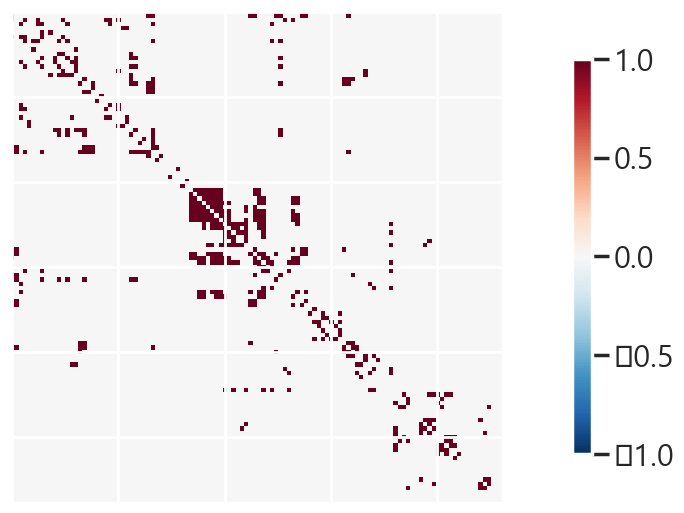

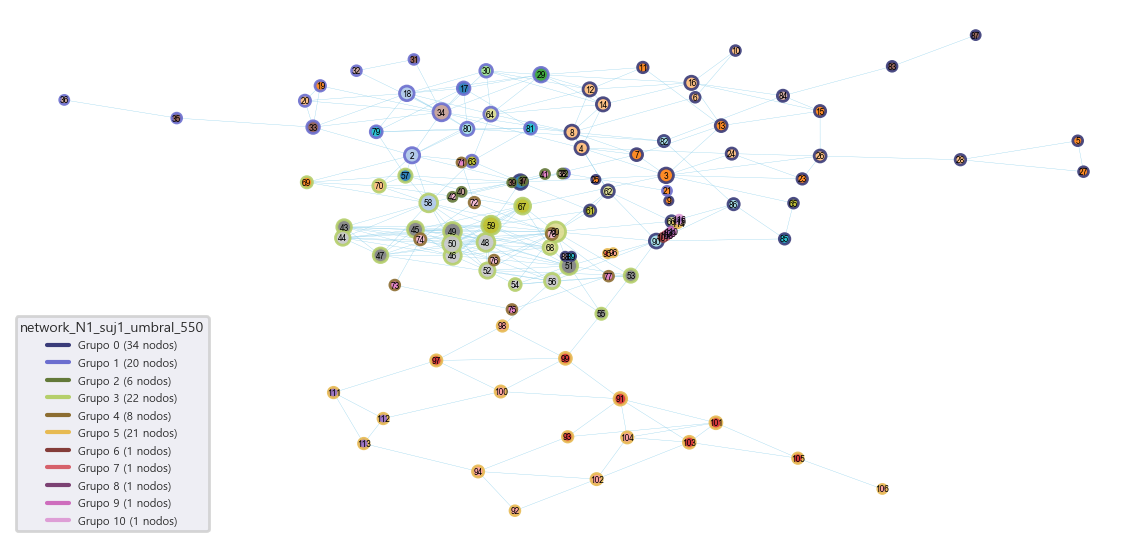

In [169]:
plot_grafo_promedio_umbral('../resources/DataSujetos/N1_suj1.csv','N1_suj1',550)